In [1]:
print("Guys lets do this")

Guys lets do this


In [2]:
import re
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [11]:
movies=pd.read_csv('movies.csv')
ratings_chunks = pd.read_csv('ratings.csv', chunksize=100000)
ratings = pd.concat(ratings_chunks)
users=pd.read_csv('users.csv')

# Display basic info
print("Movies:\n",movies.info())
print("\nRatings:\n",ratings.info())
print("\nUsers:\n",users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3706 entries, 0 to 3705
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   movie_id      3706 non-null   int64 
 1   movie_title   3706 non-null   object
 2   movie_genres  3706 non-null   object
 3   poster_url    3648 non-null   object
dtypes: int64(1), object(3)
memory usage: 115.9+ KB
Movies:
 None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   user_id      1000209 non-null  int64  
 1   movie_id     1000209 non-null  int64  
 2   user_rating  1000209 non-null  float64
 3   timestamp    1000209 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 30.5 MB

Ratings:
 None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 6 columns):
 #   Column                

In [12]:
# Download necessary resources
nltk.download('punkt_tab')

# Drop duplicates and missing values
movies.drop_duplicates(inplace=True)
movies.dropna(inplace=True)

# Split genres into lists
movies['movie_genres'] = movies['movie_genres'].apply(lambda x: x.split('|'))

# One-hot encode genres
mlb = MultiLabelBinarizer()
genres_encoded = pd.DataFrame(mlb.fit_transform(movies['movie_genres']), columns=mlb.classes_)
movies = pd.concat([movies.drop('movie_genres', axis=1), genres_encoded], axis=1)
movies['movie_title'] = movies['movie_title'].astype(str)
# Clean and tokenize titles
def clean_title(title):
    return re.sub(r'\(\d{4}\)', '', title).strip()

movies['clean_title']=movies['movie_title'].apply(clean_title)
movies['title_tokens']=movies['clean_title'].apply(word_tokenize)
movies['title_token_count']=movies['title_tokens'].apply(len)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [14]:
# Drop duplicates and missing values
ratings.drop_duplicates(inplace=True)
ratings.dropna(inplace=True)

# Convert timestamp to datetime
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

# Extract date features
ratings['year'] = ratings['timestamp'].dt.year
ratings['month'] = ratings['timestamp'].dt.month
ratings['day'] = ratings['timestamp'].dt.day

   user_id  movie_id  user_rating           timestamp  year  month  day
0      130      3107          5.0 2000-12-21 20:56:33  2000     12   21
1     3829      2114          4.0 2000-08-10 18:42:47  2000      8   10
2     1265       256          1.0 2002-01-27 03:52:32  2002      1   27
3     2896      1389          5.0 2000-10-20 01:16:45  2000     10   20
4     5264      3635          4.0 2000-06-16 18:28:31  2000      6   16


In [16]:
# Drop duplicates and missing values
users.drop_duplicates(inplace=True)
users.dropna(inplace=True)

# Convert to categorical
users['gender'] = users['user_gender'].astype('category')
users['occupation'] = users['user_occupation_label'].astype('category')

# Encode gender and occupation
users['gender_encoded'] = LabelEncoder().fit_transform(users['gender'])
users['occupation_encoded'] = LabelEncoder().fit_transform(users['occupation'])

   user_id  user_gender  bucketized_user_age  user_occupation_label  \
0      130         True                 35.0                     18   
1     3829        False                 25.0                      0   
2     1265        False                 18.0                     21   
3     2896         True                 18.0                     14   
4     5264         True                 18.0                     17   

   user_occupation_text user_zip_code gender occupation  gender_encoded  \
0   technician/engineer         50021   True         18               1   
1     academic/educator         22307  False          0               0   
2                writer         49321  False         21               0   
3       sales/marketing         60073   True         14               1   
4  college/grad student         15217   True         17               1   

   occupation_encoded  
0                  16  
1                   0  
2                  19  
3                  12  
4 

In [7]:
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')
print("\n=== Basic Dataset Information ===")
print("-" * 50)
print(f"Number of movies: {len(movies)}")
print(f"Number of ratings: {len(ratings)}")
print(f"Number of users: {len(users)}")


=== Basic Dataset Information ===
--------------------------------------------------
Number of movies: 3706
Number of ratings: 1000209
Number of users: 6040



Movies Dataset Sample:
   movie_id                   movie_title  \
0    3107.0              Backdraft (1991)   
1    2114.0         Outsiders, The (1983)   
2     256.0                 Junior (1994)   
3    1389.0               Jaws 3-D (1983)   
4    3635.0  Spy Who Loved Me, The (1977)   

                                          poster_url    0  0, 1  0, 1, 10  \
0  https://image.tmdb.org/t/p/w500/bymJtYNIdiAiBR...  0.0   0.0       0.0   
1  https://image.tmdb.org/t/p/w500/pl8Tf36TAOb2i5...  0.0   0.0       0.0   
2  https://image.tmdb.org/t/p/w500/4tRF43CbEYHmV8...  0.0   0.0       0.0   
3  https://image.tmdb.org/t/p/w500/kqDXj53F9paqVG...  0.0   0.0       0.0   
4  https://image.tmdb.org/t/p/w500/3ZxHKFxMYvAko6...  1.0   0.0       0.0   

   0, 1, 10, 16  0, 1, 13  0, 1, 13, 15  0, 1, 14  ...  9, 10  9, 13  \
0           0.0       0.0           0.0       0.0  ...    0.0    0.0   
1           0.0       0.0           0.0       0.0  ...    0.0    0.0   
2           0.0       0.0 

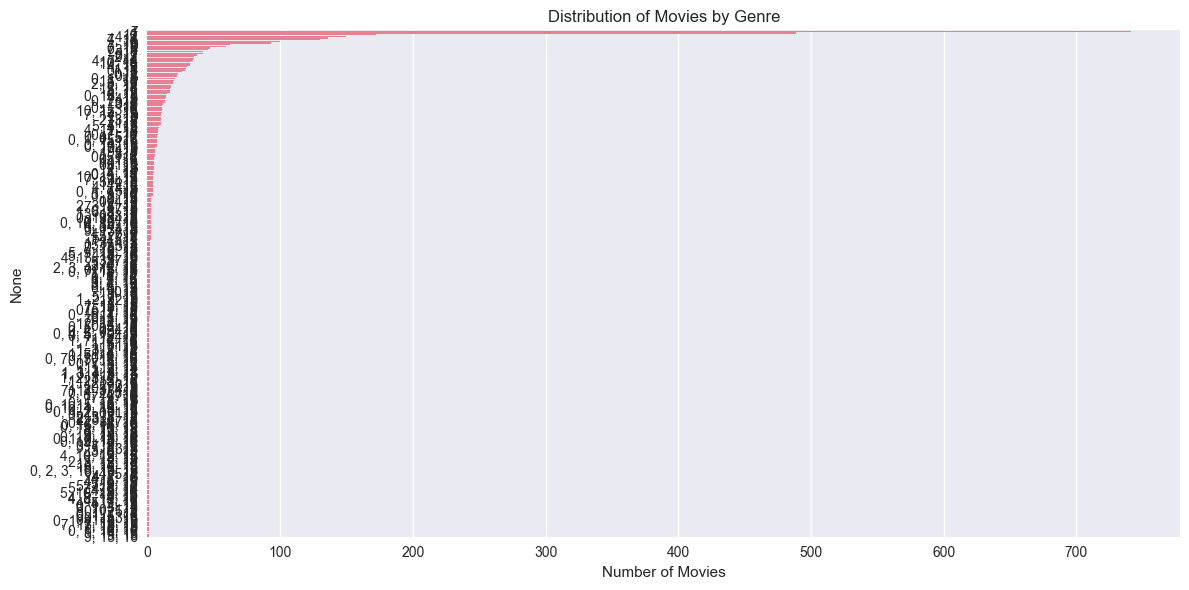

In [15]:
print("\nMovies Dataset Sample:")
print(movies.head())

# ==========================
# ✅ MOVIE GENRES ANALYSIS
# ==========================
print("\n=== Movie Genres Analysis ===")
print("-" * 50)

# Count movies per genre
genre_counts = genres_encoded.sum().sort_values(ascending=False)

# Plot genre distribution
print("Creating genre distribution plot...")
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index)
plt.title('Distribution of Movies by Genre')
plt.xlabel('Number of Movies')
plt.tight_layout()
plt.savefig('genre_distribution.png')
plt.show()

genre_df = genre_counts.reset_index()
genre_df.columns = ['Genre', 'Count']


=== Ratings Analysis ===
--------------------------------------------------
Creating ratings distribution plot...


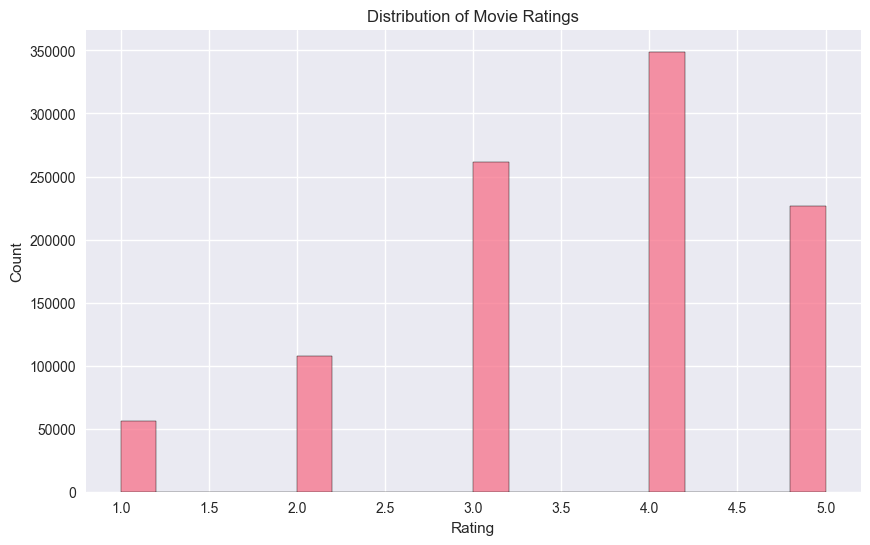

Calculating average ratings per movie...

Top 10 Highest Rated Movies (with at least 100 ratings):
      movie_id      mean  count  \
1839      2019  4.560510    628   
309        318  4.554558   2227   
802        858  4.524966   2223   
708        745  4.520548    657   
49          50  4.517106   1783   
513        527  4.510417   2304   
1066      1148  4.507937    882   
861        922  4.491489    470   
1108      1198  4.477725   2514   
843        904  4.476190   1050   

                                            movie_title  
1839  Seven Samurai (The Magnificent Seven) (Shichin...  
309                    Shawshank Redemption, The (1994)  
802                               Godfather, The (1972)  
708                               Close Shave, A (1995)  
49                           Usual Suspects, The (1995)  
513                             Schindler's List (1993)  
1066                         Wrong Trousers, The (1993)  
861       Sunset Blvd. (a.k.a. Sunset Boulevard) (1

In [21]:
# ==========================
# ✅ RATINGS ANALYSIS
# ==========================
print("\n=== Ratings Analysis ===")
print("-" * 50)

# Distribution of ratings
print("Creating ratings distribution plot...")
plt.figure(figsize=(10, 6))
sns.histplot(data=ratings, x='user_rating', bins=20)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.savefig('ratings_distribution.png')
plt.show()

# Average rating per movie
print("Calculating average ratings per movie...")
movie_ratings = ratings.groupby('movie_id')['user_rating'].agg(['mean', 'count']).reset_index()
movie_ratings = movie_ratings.merge(movies[['movie_id', 'movie_title']], on='movie_id', how='left')

print("\nTop 10 Highest Rated Movies (with at least 100 ratings):")
print(movie_ratings[movie_ratings['count'] >= 100].sort_values('mean', ascending=False).head(10))


=== User Behavior Analysis ===
--------------------------------------------------
Analyzing user rating patterns...


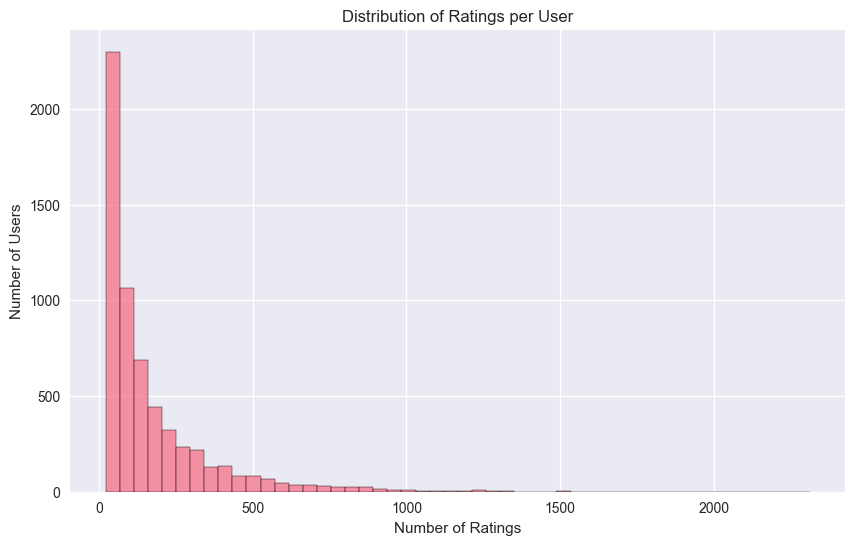


User Rating Statistics:
count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
25%        44.000000
50%        96.000000
75%       208.000000
max      2314.000000
Name: rating_count, dtype: float64

Saving analysis results...

Analysis complete! Check the generated files:
1. infotact_project1/genre_distribution.png
2. infotact_project1/ratings_distribution.png
3. infotact_project1/user_ratings_distribution.png
4. infotact_project1/movie_ratings_analysis.csv
5. infotact_project1/user_ratings_analysis.csv
6. infotact_project1/genre_analysis.csv


In [22]:
# ==========================
# ✅ USER BEHAVIOR ANALYSIS
# ==========================
print("\n=== User Behavior Analysis ===")
print("-" * 50)

# Number of ratings per user
print("Analyzing user rating patterns...")
user_ratings = ratings.groupby('user_id').size().reset_index(name='rating_count')

plt.figure(figsize=(10, 6))
sns.histplot(data=user_ratings, x='rating_count', bins=50)
plt.title('Distribution of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.savefig('user_ratings_distribution.png')
plt.show()

print("\nUser Rating Statistics:")
print(user_ratings['rating_count'].describe())

# ==========================
# ✅ EXPORT ANALYSIS FILES
# ==========================
print("\nSaving analysis results...")
movie_ratings.to_csv('movie_ratings_analysis.csv', index=False)
user_ratings.to_csv('user_ratings_analysis.csv', index=False)
genre_df.to_csv('genre_analysis.csv', index=False)

print("\nAnalysis complete! Check the generated files:")
print("1. infotact_project1/genre_distribution.png")
print("2. infotact_project1/ratings_distribution.png")
print("3. infotact_project1/user_ratings_distribution.png")
print("4. infotact_project1/movie_ratings_analysis.csv")
print("5. infotact_project1/user_ratings_analysis.csv")
print("6. infotact_project1/genre_analysis.csv")

In [23]:
df=ratings.merge(users, on='user_id').merge(movies, on='movie_id')
print(df.head())

   user_id  movie_id  user_rating   timestamp  user_gender  \
0      130      3107          5.0   977432193         True   
1     3829      2114          4.0   965932967        False   
2     1265       256          1.0  1012103552        False   
3     2896      1389          5.0   972004605         True   
4     5264      3635          4.0   961180111         True   

   bucketized_user_age  user_occupation_label  user_occupation_text  \
0                 35.0                     18   technician/engineer   
1                 25.0                      0     academic/educator   
2                 18.0                     21                writer   
3                 18.0                     14       sales/marketing   
4                 18.0                     17  college/grad student   

  user_zip_code                   movie_title  ... 9, 10  9, 13  9, 13, 16  \
0         50021              Backdraft (1991)  ...   0.0    0.0        0.0   
1         22307         Outsiders, The (1983